In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import os
import random
import timeit
from keras.models import load_model, Model
from PIL import Image
from pymongo import MongoClient
from sklearn.metrics.pairwise import euclidean_distances


MODELO = 'GPUNormal100Epoch'

Using TensorFlow backend.


In [2]:
from ajna_commons.flask.conf import DATABASE, MONGODB_URI
from padma.gym.utils import monta_lista_ids_e_imagens, view_imagens


2019-02-07 12:01:39,387 ajna         INFO     Configuração de log efetuada


Fazendo log de erros e alertas no arquivo  /home/ivan/pybr/ajna/padma/ajna_commons/flask/error.log
Fazendo log de atividade no arquivo  /home/ivan/pybr/ajna/padma/ajna_commons/flask/access.log


In [3]:
def get_cursor_indices(limit=50000, batch_size=1000):
    db = MongoClient(host=MONGODB_URI)[DATABASE]
    cursor = db['fs.files'].find(
        {'metadata.predictions.index': {'$exists': True, '$ne': None}},
        {'metadata.predictions.index': 1}
    ).limit(limit).batch_size(batch_size)
    return cursor


In [4]:
limite = 10
# Descomentar a linha abaixo para gerar todos os índices
limite = 0
cursor = get_cursor_indices(limite)

In [5]:
indexes = list(cursor)

In [6]:
len(indexes)

33879

In [7]:
print(indexes[0])

{'_id': ObjectId('5c53092d1004b3779c37d946'), 'metadata': {'predictions': [{'index': [0.6736443638801575, 1.4120619297027588, 0.0, 0.7130445241928101, 0.6505395174026489, 0.38072773814201355, 0.18435244262218475, 0.46738138794898987, 0.10572700202465057, 0.9359949231147766, 0.015766911208629608, 0.7737976908683777, 0.5064170360565186, 0.33024880290031433, 0.29400837421417236, 0.12012806534767151, 0.10113824903964996, 0.8826720118522644, 0.0, 0.7685472965240479, 0.45503973960876465, 0.2816874086856842, 0.24654878675937653, 0.17062774300575256, 0.0, 1.0443941354751587, 0.33527871966362, 0.7515670657157898, 0.49724578857421875, 0.1997106969356537, 0.27286040782928467, 0.09151515364646912, 0.5682883858680725, 0.366938054561615, 0.26661187410354614, 0.19965128600597382, 0.295163631439209, 0.08531791716814041, 0.0, 0.2753322124481201, 0.31252267956733704, 0.31653255224227905, 0.09589879214763641, 0.2981821894645691, 0.11852307617664337, 0.08470339328050613, 0.0, 0.0, 0.32297757267951965, 0.3

In [8]:
print(np.asarray(indexes[0].get('metadata').get('predictions')[0].get('index')).mean())

0.19682560436194763


In [9]:
def monta_indexes():
    np_indexes = [index.get('metadata').get('predictions')[0].get('index') for index in indexes]
    return np.asarray(np_indexes, dtype=np.float16)


In [10]:
timeit.timeit(stmt='monta_indexes()', number=1, globals=globals())


0.20289198300451972

In [11]:
np_indexes = monta_indexes()

In [12]:
print(np_indexes.shape)
print("%d kbytes" % ((np_indexes.size * np_indexes.itemsize) / 1000))

(33879, 128)
8673 kbytes


In [13]:
import time

In [14]:
def get_distances():
    i = random.randint(0, np_indexes.shape[0] - 1)
    s0 = time.time()
    distances = euclidean_distances([np_indexes[i]], np_indexes)
    s1 = time.time()
    sequence = np.argsort(distances)
    s2 = time.time()
    print(s1 - s0, s2 - s1)
    return i, distances, sequence

In [15]:
timeit.timeit(stmt='get_distances()', number=20, globals=globals())

0.03424406051635742 0.002386331558227539
0.038031578063964844 0.0030775070190429688
0.0376429557800293 0.002380847930908203
0.03800177574157715 0.003060579299926758
0.03893280029296875 0.0028009414672851562
0.03761625289916992 0.002790212631225586
0.039746999740600586 0.002398967742919922
0.03827023506164551 0.0033330917358398438
0.038043975830078125 0.0027582645416259766
0.03910207748413086 0.0023834705352783203
0.04080820083618164 0.0023903846740722656
0.0392303466796875 0.0023810863494873047
0.036733388900756836 0.002364635467529297
0.03482532501220703 0.0024175643920898438
0.03495287895202637 0.0023577213287353516
0.03624558448791504 0.00237274169921875
0.035965681076049805 0.002397775650024414
0.03502702713012695 0.0024046897888183594
0.03481435775756836 0.0024042129516601562
0.034827232360839844 0.0023965835571289062


0.8015995280002244

In [16]:
np_indexes = np.asarray(np_indexes, dtype=np.float32)
get_distances()

0.004175901412963867 0.0023615360260009766


(25057, array([[6.1711946, 2.4844556, 1.6718705, ..., 2.805295 , 6.1073174,
         1.3721672]], dtype=float32), array([[25057, 25053, 19509, ..., 26344, 21523, 23880]]))

In [17]:
timeit.timeit(stmt='get_distances()', number=20, globals=globals())

0.004244089126586914 0.002371549606323242
0.006591320037841797 0.0023605823516845703
0.007315397262573242 0.002422809600830078
0.005330324172973633 0.002448558807373047
0.003788471221923828 0.0023496150970458984
0.004094123840332031 0.002725362777709961
0.003755331039428711 0.0023407936096191406
0.003931999206542969 0.0023796558380126953
0.004389047622680664 0.0025420188903808594
0.006603240966796875 0.0026264190673828125
0.003932476043701172 0.0023484230041503906
0.0036385059356689453 0.0023355484008789062
0.003937244415283203 0.002364635467529297
0.0036268234252929688 0.002342700958251953
0.0036394596099853516 0.0023488998413085938
0.0036563873291015625 0.0023491382598876953
0.003606081008911133 0.0023636817932128906
0.0037195682525634766 0.0023565292358398438
0.003612041473388672 0.002357006072998047
0.0037260055541992188 0.002437591552734375


0.14236082400020678

In [18]:
timeit.timeit(stmt='get_distances()', number=50, globals=globals())

0.009027957916259766 0.003854513168334961
0.00674891471862793 0.002406597137451172
0.004734992980957031 0.00341033935546875
0.0038666725158691406 0.002340078353881836
0.015697717666625977 0.003470182418823242
0.004128932952880859 0.0023517608642578125
0.0036873817443847656 0.0024657249450683594
0.004146099090576172 0.0023517608642578125
0.0036513805389404297 0.002350330352783203
0.003910064697265625 0.0023572444915771484
0.007119894027709961 0.002415895462036133
0.007299661636352539 0.0025322437286376953
0.008347511291503906 0.0035703182220458984
0.003919124603271484 0.0023360252380371094
0.003713369369506836 0.0023674964904785156
0.0037047863006591797 0.002351522445678711
0.003642559051513672 0.002346515655517578
0.0037221908569335938 0.002370595932006836
0.003704071044921875 0.002353191375732422
0.0036063194274902344 0.0024607181549072266
0.0037534236907958984 0.002347230911254883
0.003841400146484375 0.002351522445678711
0.0037140846252441406 0.0023355484008789062
0.0036082267761230

0.3965672030026326

In [19]:
from gridfs import GridFS
from bson.objectid import ObjectId
import io

def mongo_image(image_id):
    """Lê imagem do Banco MongoDB. Retorna None se ID não encontrado."""
    db = MongoClient(host=MONGODB_URI)[DATABASE]
    fs = GridFS(db)
    # _id = ObjectId(image_id)
    _id = image_id
    if fs.exists(_id):
        grid_out = fs.get(_id)
        image = grid_out.read()
        return Image.open(io.BytesIO(image))
    return None

In [20]:
i, dist, seq = get_distances()
seq = seq.reshape(seq.shape[1])
seq.shape

0.0058329105377197266 0.0029282569885253906


(33879,)

In [21]:
lista_ids = [index.get('_id') for index in indexes]
lista_ids = np.asarray(lista_ids)
lista_ids[seq[0]]


ObjectId('5c530ecc1004b377f3dd1035')

In [30]:
VIRASANA_UTILS = os.path.join('..', '..', '..', '..', 'virasana', 'virasana', 'utils')

np.save(os.path.join(VIRASANA_UTILS, 'indexes.npy'), np_indexes)
np.save(os.path.join(VIRASANA_UTILS, '_ids.npy'), np.asarray(lista_ids))

0.0049839019775390625 0.0023603439331054688
[31496 13491 31507 14231 25366  3750 20681 13427 20230 20066  8419 30833
 30874  9611  9804 11028 15530  9925 15024  2332]


<Figure size 432x288 with 0 Axes>

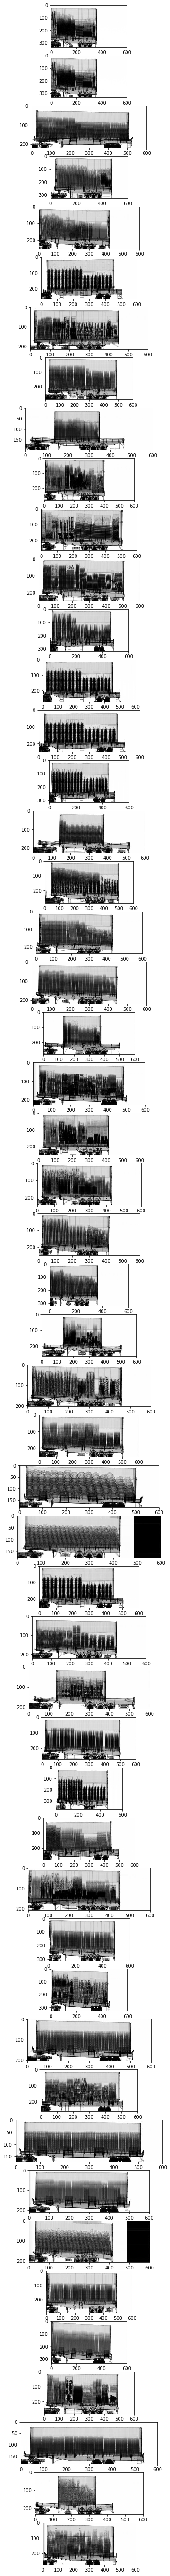

In [25]:
%matplotlib inline
i, dist, seq = get_distances()
seq = seq.reshape(seq.shape[1])
print(seq[:20])

plt.gray()
fig=plt.figure(figsize=(10, 100))
for r in range(50):
    ax = fig.add_subplot(51, 1, 1)
    plt.imshow(mongo_image(lista_ids[i]))
    ax = fig.add_subplot(51, 1, r + 2)
    plt.imshow(mongo_image(lista_ids[seq[r]]))
plt.show()